In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRFRegressor,XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines,CyclicCubicSplines
from statsmodels.gam.generalized_additive_model import LogitGam
from statsmodels.gam.tests.test_penalized import df_autos

In [5]:
from datetime import datetime
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
air_df = pd.read_stata(BytesIO(air2))


In [7]:
from datetime import datetime
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
air_df = pd.read_stata(BytesIO(air2))


air_df['date'] = pd.date_range(start=datetime(air_df.time[0], 1, 1), periods=len(air_df), freq='MS')
air_df['lnair'] = np.log(air_df['air'])


In [8]:
data = air_df[['date','air']]
data.columns = ['month', 'passengers']
data.head()

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


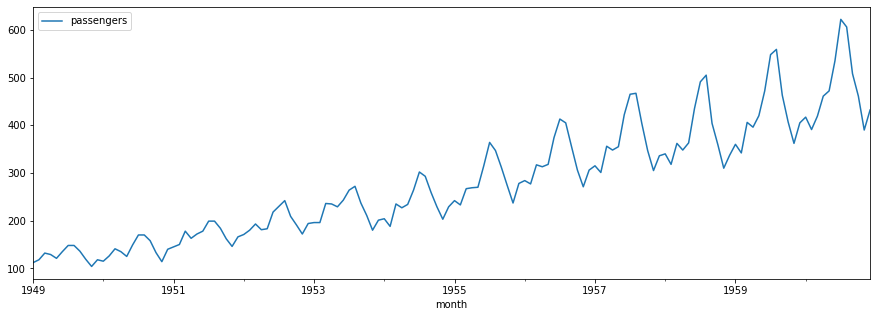

In [9]:
data['month'] = pd.to_datetime(data['month'],format='%Y-%m')
data = data.set_index('month')
data.plot(figsize=(15,5))
plt.show()

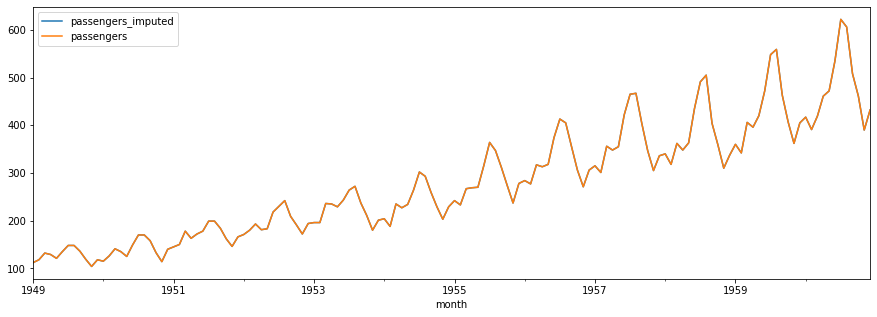

In [10]:
data['passengers_imputed'] = data.passengers.interpolate(method='cubic')
data[['passengers_imputed','passengers']].plot(figsize=(15,5))
plt.show()

In [11]:
data['passengers_lag1'] = data['passengers_imputed'].shift(1)
data['passengers_lag2'] = data['passengers_imputed'].shift(2)
data['year'] = data.index.year
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['week'] = data.index.week
data['week_dat'] = data.index.weekday
data['rolling_mean3'] = data['passengers_imputed'].rolling(3).mean()
data['rolling_mean3'] = data['passengers_imputed'].rolling(3).mean()
data = data.dropna()
data.head()

,passengers,passengers_imputed,passengers_lag1,passengers_lag2,year,month,quarter,week,week_dat,rolling_mean3
month,,,,,,,,,,
1949-03-01,132,132,118.0,112.0,1949,3,1,9,1,120.666667
1949-04-01,129,129,132.0,118.0,1949,4,2,13,4,126.333333
1949-05-01,121,121,129.0,132.0,1949,5,2,17,6,127.333333
1949-06-01,135,135,121.0,129.0,1949,6,2,22,2,128.333333
1949-07-01,148,148,135.0,121.0,1949,7,3,26,4,134.666667


In [12]:
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean((np.abs(y_true-y_pred)/y_true))*100,2)

In [13]:
print("Minimum Year",min(data['year']))
print("Maximum Year",max(data['year']))
train_dt = data[data.index< '1959-01-01']

print("Minimum Year",min(train_dt['year']))
print("Maximum Year",max(train_dt['year']))

Minimum Year 1949
Maximum Year 1960
Minimum Year 1949
Maximum Year 1958


In [14]:
test_dt = data[data.index >= '1959-01-01']

print("Minimum Year",min(test_dt['year']))
print("Maximum Year",max(test_dt['year']))

Minimum Year 1959
Maximum Year 1960


### Model deployment

In [15]:
xgbrfm = XGBRegressor(learning_rate=1,max_depth=3,gamma=.01,reg_alpha=.5,reg_lambda=.5)
xgbrfm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0.01,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=0.5, reg_lambda=0.5, ...)

In [16]:
X = train_dt[['passengers_lag1','passengers_lag2','year','month','quarter','week','week_dat','rolling_mean3']]
y = train_dt['passengers_imputed']
xgbrfm = xgbrfm.fit(X,y)

In [17]:
prediction = xgbrfm.predict(test_dt[['passengers_lag1','passengers_lag2','year','month','quarter','week','week_dat','rolling_mean3']])
test_dt['prediction_xgbrf'] = prediction

In [18]:
mape(test_dt['passengers_imputed'],test_dt['prediction_xgbrf'])

9.59

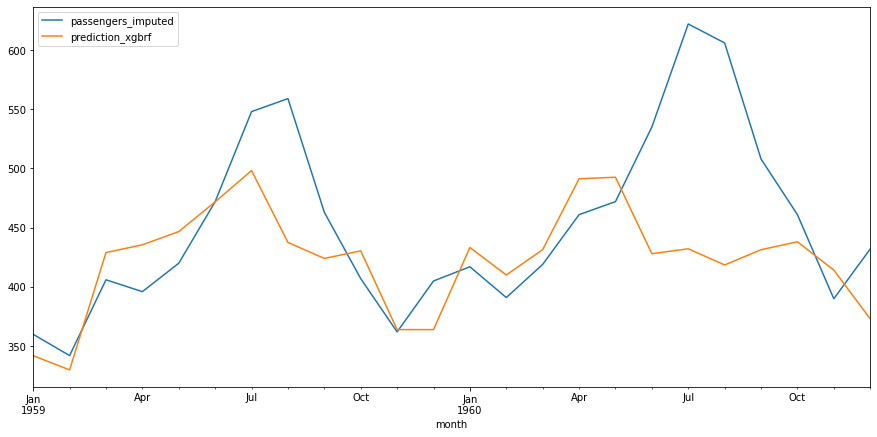

In [19]:
test_dt[['passengers_imputed','prediction_xgbrf']].plot(figsize=(15,7))
plt.show()

# XGboost Hybrid (XGB + GAM inputs)

In [34]:
air_df = air_df.set_index('date')
air_df.head()

,air,time,t,lnair,year,week,month,quarter,weekday
date,,,,,,,,,
1949-01-01,112,1949.000000,1.0,4.718499,1949,53,1,1,5
1949-02-01,118,1949.083374,2.0,4.770685,1949,5,2,1,1
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6


In [35]:

air_df['year']= air_df.index.year
air_df['week']= air_df.index.week
air_df['month']= air_df.index.month
air_df['quarter']= air_df.index.quarter
air_df['weekday']= air_df.index.weekday
air_df['year_half'] = np.where(air_df['month']<=6,1,2)
air_df.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half
date,,,,,,,,,,
1949-01-01,112,1949.000000,1.0,4.718499,1949,53,1,1,5,1
1949-02-01,118,1949.083374,2.0,4.770685,1949,5,2,1,1,1
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1


In [36]:
air_df_train = air_df[air_df.index < '1958-01-01']
air_df_test = air_df[air_df.index >= '1958-01-01']

In [37]:
air_df_train.groupby('month')['air'].ewm(com=1).mean()

month  date      
1      1949-01-01    112.000000
       1950-01-01    114.000000
       1951-01-01    131.714286
       1952-01-01    152.666667
       1953-01-01    175.032258
                        ...    
12     1953-12-01    188.064516
       1954-12-01    208.857143
       1955-12-01    243.700787
       1956-12-01    274.972549
       1957-12-01    305.545988
Name: air, Length: 108, dtype: float64

In [38]:
# round(air_df_train.groupby('month')['air'].ewm(com=1).mean().groupby('month').max(),2)
air_df_train['month_avg']= round(air_df_train.groupby('month')['air'].ewm(com=.1).mean(),2).values

month_avg = dict(round(air_df_train.groupby('month')['air'].ewm(span=2).mean().groupby('month').max(),2))
air_df_train['month_avg_max']= air_df_train['month'].map(month_avg)
month_avg 

{1: 298.35,
 2: 286.43,
 3: 336.07,
 4: 329.74,
 5: 335.72,
 6: 397.14,
 7: 439.27,
 8: 437.45,
 9: 380.5,
 10: 327.76,
 11: 288.27,
 12: 320.66}

In [39]:
air_df_train['month_wavg'] = (air_df_train['month_avg_max']+air_df_train['month_avg'])/2
air_df_train['month_wavg2'] = (air_df_train['air']*.45+air_df_train['month_avg_max']*.45+air_df_train['month_avg']*.1)
air_df_train.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half,month_avg,month_avg_max,month_wavg,month_wavg2
date,,,,,,,,,,,,,,
1949-01-01,112,1949.000000,1.0,4.718499,1949,53,1,1,5,1,112.00,298.35,205.175,195.8575
1949-02-01,118,1949.083374,2.0,4.770685,1949,5,2,1,1,1,114.75,286.43,200.590,193.4685
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1,142.27,336.07,239.170,224.8585
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1,168.39,329.74,249.065,223.2720
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1,193.49,335.72,264.605,224.8730


,air,month_avg,month_wavg,month_wavg2
date,,,,
1949-04-01,129,168.39,249.065,223.272
1950-04-01,135,228.96,279.350,232.029
1951-04-01,163,129.00,229.370,234.633
1952-04-01,181,181.61,255.675,247.994
1953-04-01,235,310.17,319.955,285.150
1954-04-01,227,148.00,238.870,265.333
1955-04-01,269,206.50,268.120,290.083
1956-04-01,313,269.74,299.740,316.207
1957-04-01,348,118.00,223.870,316.783


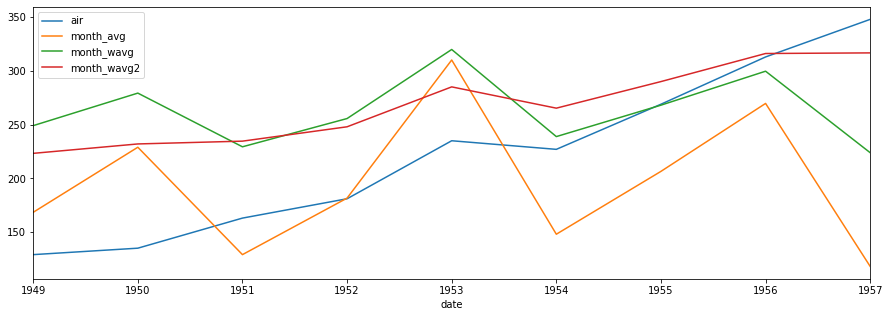

In [40]:
air_df_train[air_df_train.month==4][['air','month_avg','month_wavg','month_wavg2']].plot(kind='line',figsize=(15,5))
air_df_train[air_df_train.month==4][['air','month_avg','month_wavg','month_wavg2']]

In [41]:
## Data transformation by BSpline
weights = [0.223744292,0.319634703,0.456621005]

air_df_train['air_3ma'] = air_df_train['air'].rolling(3).apply(lambda x: np.average(x,weights=weights))
air_df_train['air_lag'] = air_df_train['air'].shift(1)
air_df_train = air_df_train.dropna()

In [42]:
import statsmodels.api as sm
x_spline = air_df_train[['year_half','quarter','month']]
bs = BSplines(x_spline, df=[4,4,6], degree=[3,3,2])
# cs = CyclicCubicSplines(x_spline, df=[3,3,5,5])
alpha = np.array([21833888.8, 6460.38479])

#family=sm.families.Gamma()
model = GLMGam(air_df_train.air,exog=air_df_train[['year','t','air_lag']],smoother=bs)

temp= bs.transform(air_df_train[['year_half','quarter','month']].values)

df_trans=pd.DataFrame(temp, columns=bs.col_names)

for x in bs.col_names:
    air_df_train[x] = np.array(df_trans[x])

In [43]:
model_fit = model.fit()

In [44]:
exo_var = ['year','t','air_lag']
spline_var = ['year_half','quarter','month']
prediction = model_fit.predict(air_df_train[exo_var],air_df_train[spline_var].values)
air_df_train['gam_predcition'] = prediction

In [45]:
air_df_train.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half,...,year_half_s2,quarter_s0,quarter_s1,quarter_s2,month_s0,month_s1,month_s2,month_s3,month_s4,gam_predcition
date,,,,,,,,,,,,,,,,,,,,,
1949-03-01,132,1949.166626,3.0,4.882802,1949,9,3,1,1,1,...,0.0,0.000000,0.000000,0.000000,0.666667,0.222222,0.000000,0.0,0.0,133.127222
1949-04-01,129,1949.250000,4.0,4.859812,1949,13,4,2,4,1,...,0.0,0.444444,0.222222,0.037037,0.500000,0.500000,0.000000,0.0,0.0,112.250477
1949-05-01,121,1949.333374,5.0,4.795791,1949,17,5,2,6,1,...,0.0,0.444444,0.222222,0.037037,0.222222,0.719807,0.057971,0.0,0.0,136.424202
1949-06-01,135,1949.416626,6.0,4.905275,1949,22,6,2,2,1,...,0.0,0.444444,0.222222,0.037037,0.055556,0.712560,0.231884,0.0,0.0,141.053424
1949-07-01,148,1949.500000,7.0,4.997212,1949,26,7,3,4,2,...,1.0,0.222222,0.444444,0.296296,0.000000,0.478261,0.521739,0.0,0.0,160.094197


In [46]:
air_df_train.columns

Index(['air', 'time', 't', 'lnair', 'year', 'week', 'month', 'quarter',
       'weekday', 'year_half', 'month_avg', 'month_avg_max', 'month_wavg',
       'month_wavg2', 'air_3ma', 'air_lag', 'year_half_s0', 'year_half_s1',
       'year_half_s2', 'quarter_s0', 'quarter_s1', 'quarter_s2', 'month_s0',
       'month_s1', 'month_s2', 'month_s3', 'month_s4', 'gam_predcition'],
      dtype='object')

## Model Training

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRFRegressor,XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [48]:
xgbrfm = XGBRegressor(learning_rate=1,max_depth=3,gamma=.01,reg_alpha=.5,reg_lambda=.5)

In [49]:
X = air_df_train.drop(columns='air')
y = air_df_train['air']

xgbrfm = xgbrfm.fit(X,y)

air_df_train['xgb_predcition']= xgbrfm.predict(X)

<AxesSubplot:xlabel='date'>

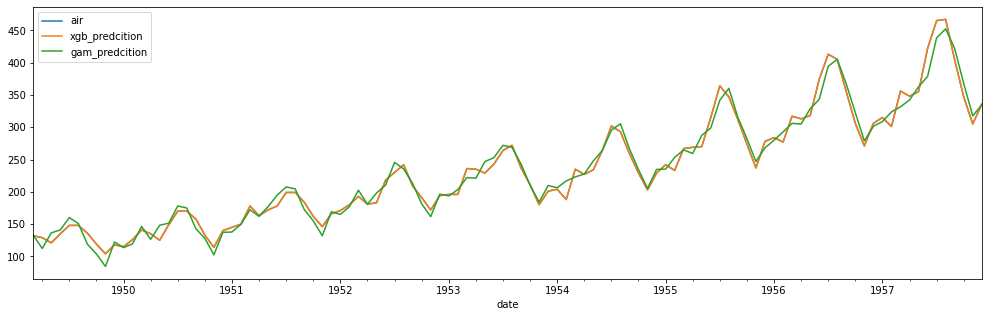

In [50]:
air_df_train[['air','xgb_predcition','gam_predcition']].plot(kind='line',figsize=(17,5))

In [54]:
print("xgb_predcition", mape(air_df_train['air'],air_df_train['xgb_predcition']))

print("gam_predcition", mape(air_df_train['air'],air_df_train['gam_predcition']))

xgb_predcition 0.04
gam_predcition 4.58


## Test

In [55]:
## Data Transformation
air_df_test['month_avg']= round(air_df_test.groupby('month')['air'].ewm(com=.1).mean(),2).values

month_avg = dict(round(air_df_test.groupby('month')['air'].ewm(span=2).mean().groupby('month').max(),2))
air_df_test['month_avg_max']= air_df_test['month'].map(month_avg)
month_avg

{1: 397.92,
 2: 374.08,
 3: 411.62,
 4: 437.31,
 5: 451.62,
 6: 512.77,
 7: 594.85,
 8: 587.38,
 9: 489.62,
 10: 440.69,
 11: 377.38,
 12: 418.46}

In [56]:
air_df_test['month_wavg'] = (air_df_test['month_avg_max']+air_df_test['month_avg'])/2
air_df_test['month_wavg2'] = (air_df_test['air']*.45+air_df_test['month_avg_max']*.45+air_df_test['month_avg']*.1)

In [64]:
def forward_predict(pred_df,train_df,com,train_model,exog_var,spline_var):
    train_l3 = train_df.tail(5)
    pred_df['air_3ma'] = np.nan
    pred_df['air'] = np.nan
    pred_df['air_lag'] = np.nan
    
    
    for x in range(0,len(pred_df)):
        if x==0:
            avg = train_l3.iloc[len(train_l3)-1]['air_3ma']*(0.223744292)+\
            train_l3.iloc[len(train_l3)-2]['air_3ma']*(0.319634703)+\
            train_l3.iloc[len(train_l3)-3]['air_3ma']*(0.456621005)
            print("Average:",avg)
            pred_df.iloc[x:x+1]['air_3ma']= avg
            pred_df.iloc[x:x+1]['air_lag']= train_l3.iloc[len(train_l3)-1]['air']
            print("air_3ma:",pred_df.iloc[x:x+1]['air_3ma'])
          
            
            prediction = train_model.predict(pred_df[exog_var].iloc[x:x+1],pred_df[spline_var].iloc[x:x+1].values)
            pred_df.iloc[x:x+1]['air'] = prediction
            train_l3 = train_l3.append(pred_df.iloc[x:x+1])
            
        else:
            avg = train_l3.iloc[len(train_l3)-1]['air_3ma']*(0.223744292)+\
            train_l3.iloc[len(train_l3)-2]['air_3ma']*(0.319634703)+\
            train_l3.iloc[len(train_l3)-3]['air_3ma']*(0.456621005)

            pred_df.iloc[x:x+1]['air_3ma']=avg
            pred_df.iloc[x:x+1]['air_lag']= train_l3.iloc[len(train_l3)-1]['air']
            prediction = train_model.predict(pred_df.iloc[x:x+1][exog_var],pred_df.iloc[x:x+1][spline_var].values)
            pred_df.iloc[x:x+1]['air'] = prediction
            train_l3 = train_l3.append(pred_df.iloc[x:x+1])
#             print(pred_df)
    return pred_df


def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean((np.abs(y_true-y_pred)/y_true))*100,2)

In [61]:
import statsmodels.api as sm
x_spline = air_df_train[['year_half','quarter','month']]
bs = BSplines(x_spline, df=[4,4,6,5], degree=[3,3,2,3])
cs = CyclicCubicSplines(x_spline, df=[3,3,5,5])
alpha = np.array([21833888.8, 6460.38479])
#family=sm.families.Gamma()
model = GLMGam(air_df_train.air,exog=air_df_train[['year','t','air_lag']],smoother=bs)

df_trans= bs.transform(air_df_train[['year_half','quarter','month','air_lag']].values)

pd.DataFrame(df_trans, columns=bs.col_names)

,year_half_s0,year_half_s1,year_half_s2,quarter_s0,quarter_s1,quarter_s2,month_s0,month_s1,month_s2,month_s3,month_s4
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.666667,0.222222,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.500000,0.500000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.222222,0.719807,0.057971,0.000000,0.000000
3,0.0,0.0,0.0,0.444444,0.222222,0.037037,0.055556,0.712560,0.231884,0.000000,0.000000
4,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.478261,0.521739,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
101,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.193676,0.733597,0.072727,0.000000
102,0.0,0.0,1.0,0.222222,0.444444,0.296296,0.000000,0.035573,0.673518,0.290909,0.000000
103,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.355556,0.632099,0.012346
104,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.088889,0.602469,0.308642


In [62]:
ma_model = model.fit()
ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    air   No. Observations:                  106
Model:                         GLMGam   Df Residuals:                       95
Model Family:                Gaussian   Df Model:                        10.00
Link Function:               identity   Scale:                          174.11
Method:                         PIRLS   Log-Likelihood:                -418.06
Date:                Thu, 19 May 2022   Deviance:                       16540.
Time:                        11:31:13   Pearson chi2:                 1.65e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
year             0.0078      0.003      2.277      0.023       0.001       0.014
t                0.6034      0.177      3.411      0.001       0.257       0.950
air_lag          0.7678      0.068     11.260      0.000       0.634       0.901
year_half_s0  1.746e-14   1.47e-14      1.190      0.234   -1.13e-14    4.62e-14
year_half_s1 -1.503e-14   2.48e-14     -0.607      0.544   -6.36e-14    3.35e-14
year_half_s2     3.8386      9.848      0.390      0.697     -15.463      23.140
quarter_s0    -110.0324     19.227     -5.723      0.000    -147.717     -72.348
quarter_s1     -50.7263      9.317     -5.444      0.000     -68.987     -32.465
quarter_s2     -14.6256     18.929     -0.773      0.440     -51.726      22.475
month_s0         3.4474      8.314      0.415      0.678     -12.849      19.743
month_s1       104.6269     14.983      6.983      0.000      75.262     133.992
month_s2        66.1299     18.533      3.568      0.000      29.806     102.453
month_s3       -55.3557     22.935     -2.414      0.016    -100.308     -10.403
month_s4        30.9338     19.024      1.626      0.104      -6.352      68.220
================================================================================
"""

In [65]:
pred_df= forward_predict(air_df_test,air_df_train,0.1,ma_model,['year','t','air_lag'],['year_half','quarter','month'])

Average: 361.39815683346137
air_3ma: date
1958-01-01    361.398157
Name: air_3ma, dtype: float64


In [66]:
air_df_test['gam_predcition'] = pred_df['air']
air_df_test['air_3ma'] = pred_df['air_3ma']

air_df_test.head()

,air,time,t,lnair,year,week,month,quarter,weekday,year_half,month_avg,month_avg_max,month_wavg,month_wavg2,air_3ma,air_lag,gam_predcition
date,,,,,,,,,,,,,,,,,
1958-01-01,338.980535,1958.000000,109.0,5.828946,1958,1,1,1,2,1,340.00,397.92,368.960,366.0640,361.398157,336.000000,338.980535
1958-02-01,349.408605,1958.083374,110.0,5.762052,1958,5,2,1,5,1,358.33,374.08,366.205,347.2690,341.391414,338.980535,349.408605
1958-03-01,376.030829,1958.166626,111.0,5.891644,1958,9,3,1,5,1,411.71,411.62,411.665,389.3000,341.923751,349.408605,376.030829
1958-04-01,364.845186,1958.250000,112.0,5.852202,1958,14,4,2,1,1,318.00,437.31,377.655,385.1895,350.646020,376.030829,364.845186
1958-05-01,382.734131,1958.333374,113.0,5.894403,1958,18,5,2,3,1,340.00,451.62,395.810,400.5790,343.632233,364.845186,382.734131


### data Transformation

In [67]:
temp= bs.transform(air_df_test[['year_half','quarter','month']].values)

df_trans=pd.DataFrame(temp, columns=bs.col_names)

for x in bs.col_names:
    air_df_test[x] = np.array(df_trans[x])

### Prediction

In [76]:
X = air_df_train.drop(columns=['air'])
y = air_df_train['air']

X_test = air_df_test.drop(columns=['air'])
y_test = air_df_test['air']


xgbrfm = xgbrfm.fit(X,y)

air_df_test['xgb_predcition']= xgbrfm.predict(X_test)

In [75]:
air_df_train.columns

Index(['air', 'time', 't', 'lnair', 'year', 'week', 'month', 'quarter',
       'weekday', 'year_half', 'month_avg', 'month_avg_max', 'month_wavg',
       'month_wavg2', 'air_3ma', 'air_lag', 'year_half_s0', 'year_half_s1',
       'year_half_s2', 'quarter_s0', 'quarter_s1', 'quarter_s2', 'month_s0',
       'month_s1', 'month_s2', 'month_s3', 'month_s4', 'gam_predcition',
       'xgb_predcition'],
      dtype='object')

xgb_predcition: 4.56
gam_predcition: 0.0


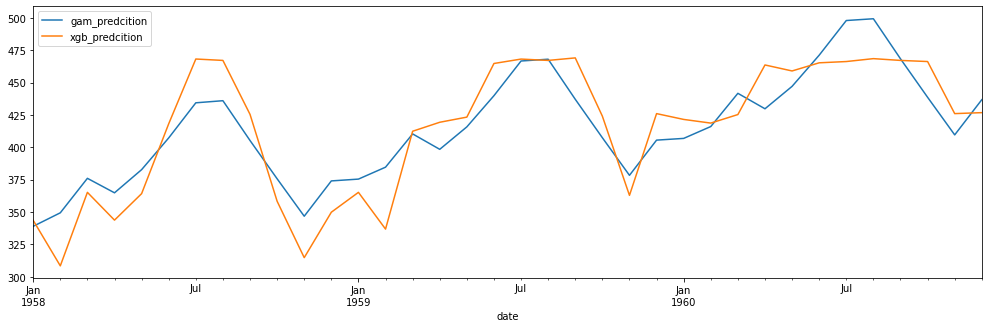

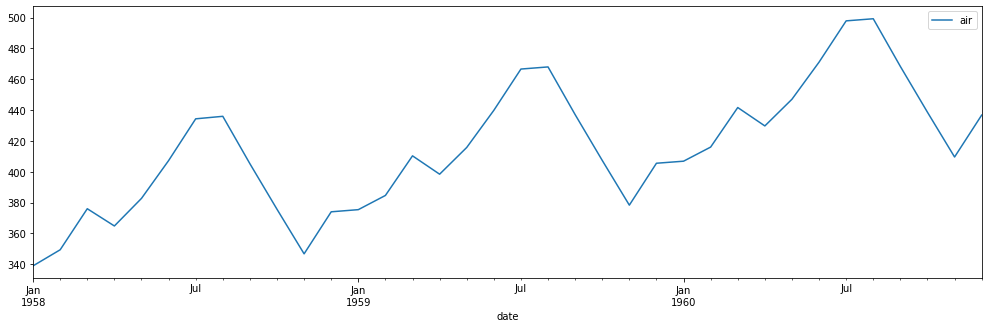

In [77]:
print('xgb_predcition:',mape(air_df_test['air'],air_df_test['xgb_predcition']))
print('gam_predcition:',mape(air_df_test['air'],air_df_test['gam_predcition']))
air_df_test[['gam_predcition','xgb_predcition']].plot(kind='line',figsize=(17,5))
air_df_test[['air']].plot(kind='line',figsize=(17,5))
plt.show()

<AxesSubplot:xlabel='date'>

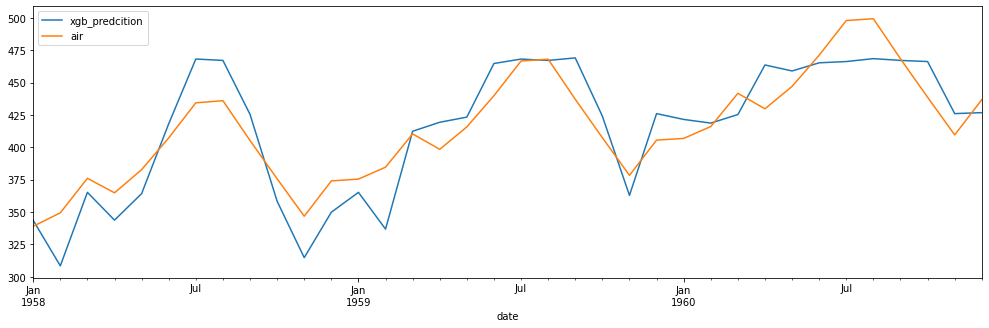

In [78]:
air_df_test[['xgb_predcition','air']].plot(kind='line',figsize=(17,5))